In [ ]:
%%capture
%load_ext autoreload
%autoreload 2
%reset -f

In [ ]:
from collections import abc

import numpy as np
from matplotlib import pyplot as plt

from harmonic_balance import arclength_continuation as alc
from harmonic_balance import freq

ndarray = np.ndarray

## Define nonlinear force

In [ ]:
def get_slice(dof: int, N: int):
    return np.s_[dof * N : (dof + 1) * N]


def get_nonlinear(
    factor: float,
) -> tuple[
    abc.Callable[[ndarray, ndarray, int], ndarray],
    abc.Callable[[ndarray, ndarray, int], ndarray],
    abc.Callable[[ndarray, ndarray, int], ndarray],
]:
    dof = 0
    s_ = lambda N: get_slice(dof, N)

    def f_nl(x: ndarray, xdot: ndarray, N: int) -> ndarray:
        res = np.zeros_like(x, dtype=float)
        res[s_(N)] += factor * x[s_(N)] ** 3
        return res

    def df_nl_dx(x: ndarray, xdot: ndarray, N: int) -> ndarray:
        res = np.zeros_like(x, dtype=float)
        res[s_(N)] += factor * 3 * x[s_(N)] ** 2
        return np.diag(res)

    def df_nl_d_xdot(x: ndarray, xdot: ndarray, N: int) -> ndarray:
        shape = x.shape[0]
        return np.zeros((shape, shape), dtype=float)

    return f_nl, df_nl_dx, df_nl_d_xdot

## Define system

In [ ]:
alpha = 1
beta = 0.25
delta = 0.1
gamma = 2.5

omega = 2
n = 1

m1 = 1
c1 = delta
k1 = alpha

M = np.array([[m1]])
C = np.array([[c1]])
K = np.array([[k1]])

ks = (1,)
dofs = (0,)
is_cosines = (1,)
coefficients = (gamma,)

factor = beta
f_nl, df_nl_dx, df_nl_d_xdot = get_nonlinear(factor)

## Set harmonic balance parameters

In [ ]:
NH = 30
N = 256

b_ext = freq.get_b_ext(NH, n, ks, dofs, is_cosines, coefficients)

## Compute NLFR curve

In [ ]:
omega_i0 = 1.7

num_points = 100
s = 0.02
tol = 1e-4
max_iter = 100

ys0, rel_errors0, convergeds0, iters0 = alc.compute_nlfr_curve(
    num_points,
    omega_i0,
    b_ext,
    f_nl,
    df_nl_dx,
    df_nl_d_xdot,
    NH,
    n,
    N,
    s,
    M,
    C,
    K,
    tol,
    max_iter,
)

iteration 019 didn't converge
iteration 020 didn't converge
Traceback (most recent call last):
  File "/home/schilln/documents/harmonic_balance/src/harmonic_balance/arclength_continuation.py", line 130, in compute_nlfr_curve
    ys[i], rhs, convergeds[i], iters[i] = correct_y(
  File "/home/schilln/documents/harmonic_balance/src/harmonic_balance/arclength_continuation.py", line 323, in correct_y
    step = _solve_step(
  File "/home/schilln/documents/harmonic_balance/src/harmonic_balance/arclength_continuation.py", line 466, in _solve_step
    step = np.linalg.solve(jacobian, -rhs)
  File "/home/schilln/documents/harmonic_balance/.venv/lib/python3.10/site-packages/numpy/linalg/_linalg.py", line 410, in solve
    r = gufunc(a, b, signature=signature)
  File "/home/schilln/documents/harmonic_balance/.venv/lib/python3.10/site-packages/numpy/linalg/_linalg.py", line 104, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix



In [ ]:
omega_i0 = 1.73

num_points = 30

ys1, rel_errors1, convergeds1, iters1 = alc.compute_nlfr_curve(
    num_points,
    omega_i0,
    b_ext,
    f_nl,
    df_nl_dx,
    df_nl_d_xdot,
    NH,
    n,
    N,
    s,
    M,
    C,
    K,
    tol,
    max_iter,
)

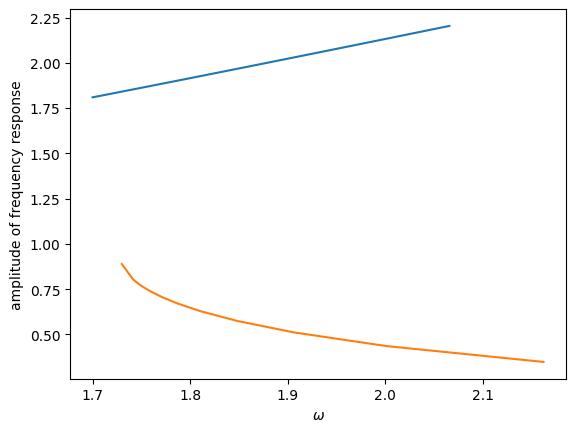

In [ ]:
is_inf = np.any(np.isinf(ys0), axis=1) | (ys0[:, -1] > 1e2)
amplitudes0 = np.linalg.norm(ys0[~is_inf][:, :-1], axis=1)
omegas0 = ys0[~is_inf][:, -1].real

amplitudes1 = np.linalg.norm(ys1[:, :-1], axis=1)
omegas1 = ys1[:, -1].real

fig, ax = plt.subplots(1, 1)

ax.plot(omegas0, amplitudes0)

s_ = np.s_[:13]
ax.plot(omegas1[s_], amplitudes1[s_])

ax.set_xlabel("$\omega$")
ax.set_ylabel("amplitude of frequency response")

plt.show()